# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv("bikes_rent.csv")

In [3]:
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

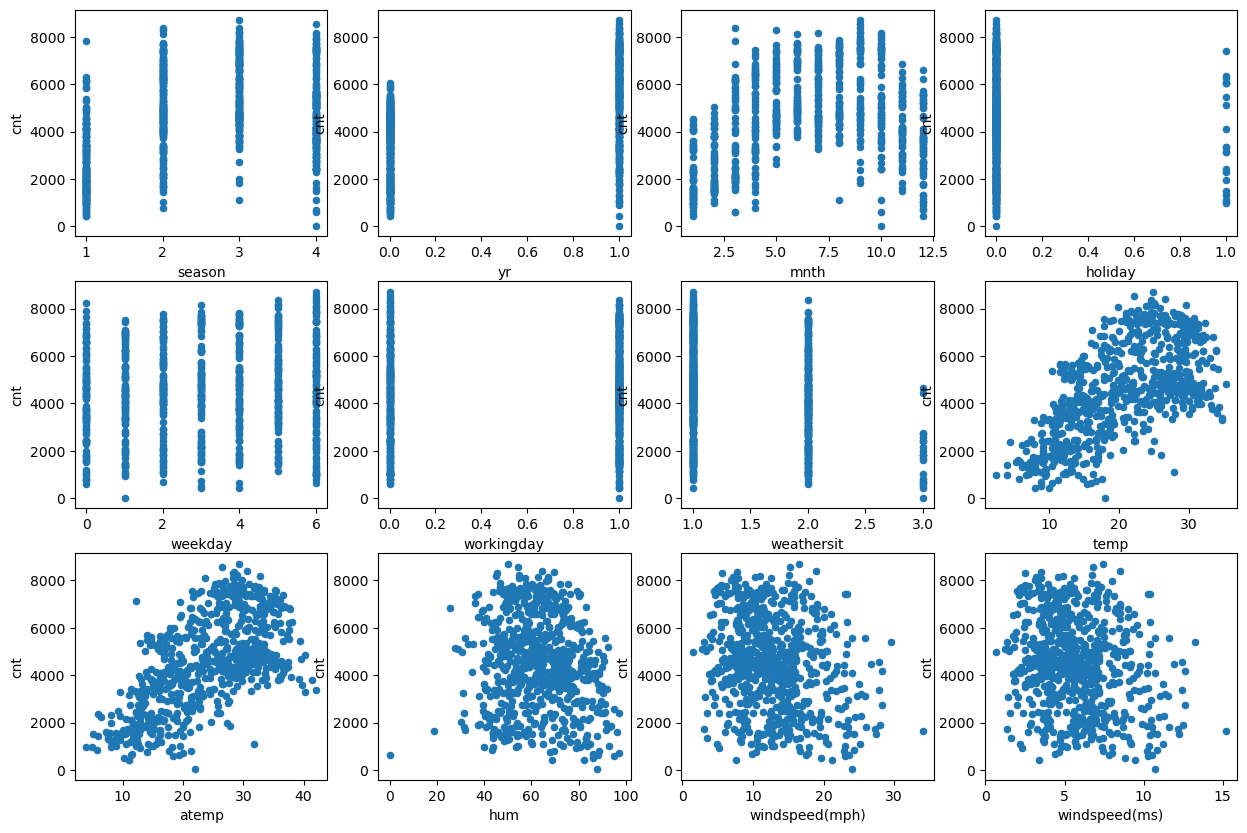

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

#### 1. [0.5 балла] Укажите один или два признака, от которых число прокатов скорее всего зависит линейно. Каким способом можно более строго оценить уровень линейной зависимости между признаками и целевой переменной? Сделайте это.
   * ответ: скорее всего зависит линейно от температуры и ощущаемой температуры
   

<Axes: title={'center': 'Dependence of count on atemp'}, xlabel='atemp', ylabel='cnt'>

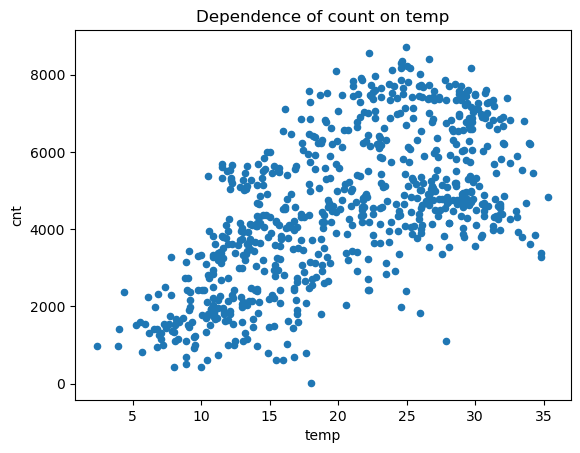

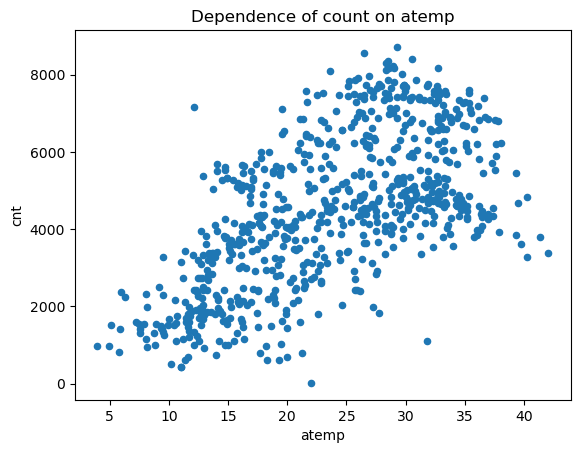

In [5]:
df.plot.scatter(x = "temp", y = "cnt", title ="Dependence of count on temp")
df.plot.scatter(x = "atemp", y = "cnt", title ="Dependence of count on atemp")

Степень линейной зависимости можно определить по коэффициенту Пирсона.

In [6]:
import scipy

print(scipy.stats.pearsonr(x = df["temp"], y=df["cnt"]).statistic, scipy.stats.pearsonr(x = df["atemp"], y=df["cnt"]).statistic)

0.6274940090334917 0.6310656998491809


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

#### 2. [0.5 балла] Посчитайте попарные корреляции между вещественными признаками.

In [7]:
df[["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

#### 3. [0.5 балла] Выведите средние значения признаков.

In [8]:
for column in df.columns:
    print(column, ":", np.mean(df[column]))

season : 2.496580027359781
yr : 0.5006839945280438
mnth : 6.519835841313269
holiday : 0.028727770177838577
weekday : 2.997264021887825
workingday : 0.6839945280437757
weathersit : 1.3953488372093024
temp : 20.31077632886457
atemp : 23.717699432284544
hum : 62.78940629274965
windspeed(mph) : 12.762576179069768
windspeed(ms) : 5.705219570438215
cnt : 4504.3488372093025


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

#### 4. [1 балл] Выполните нормирование признаков и перемешайте данные.

In [9]:
from sklearn.preprocessing import StandardScaler, scale

df_cnt = df.drop(columns='cnt')
df_new = pd.DataFrame(StandardScaler().fit_transform(df_cnt),columns=df_cnt.columns)
df_new["cnt"]=df["cnt"]
df = df_new
df = df.sample(frac=1)

In [10]:
df.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
569,0.453512,0.998633,0.139196,-0.171981,-0.996930,0.679706,-0.726048,1.346351,1.324307,0.465623,-0.668905,-0.668905,6966
281,1.354375,-1.001369,1.008875,-0.171981,-1.496077,-1.471225,-0.726048,0.248452,0.304754,0.699816,-1.640344,-1.640344,5511
11,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.763873,-1.927428,-0.199176,1.473833,1.473833,1162
509,-0.447350,0.998633,-0.440589,-0.171981,0.500513,0.679706,-0.726048,0.872568,0.812688,0.623705,-0.227132,-0.227132,6770
533,-0.447350,0.998633,-0.150697,-0.171981,-1.496077,-1.471225,-0.726048,0.530900,0.599455,-0.204762,-0.588576,-0.588576,6978
374,-1.348213,0.998633,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.020571,-0.955040,0.130877,-0.037888,-0.037888,3598
299,1.354375,-1.001369,1.008875,-0.171981,0.500513,0.679706,1.110427,-0.138771,-0.106282,1.299942,0.093961,0.093961,2659
174,0.453512,-1.001369,-0.150697,-0.171981,0.999661,0.679706,-0.726048,1.250683,1.119001,-0.383338,0.407242,0.407242,4991
294,1.354375,-1.001369,1.008875,-0.171981,1.498809,-1.471225,-0.726048,-0.398439,-0.300044,0.008943,-1.263086,-1.263086,4308
51,-1.348213,-1.001369,-1.310268,5.814596,-0.996930,-1.471225,1.110427,-1.049889,-1.168433,-0.160850,1.515398,1.515398,1107


#### 5. [1 балл] Обучите линейную регрессию на всех данных и выведите веса модели.

Веса хранятся в переменной coef_ класса регрессора.

Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python.

Названия признаков хранятся в переменной df.columns

In [11]:
from sklearn.linear_model import LinearRegression

regr1 = LinearRegression()
regr1.fit(df.drop(columns = "cnt"), df["cnt"])

for i in range(len(df.columns)-1):
    print(df.columns[i],": ", regr1.coef_[i])

season :  570.8692224896922
yr :  1021.9718726862621
mnth :  -141.3033136761298
holiday :  -86.7566199460402
weekday :  137.22398270701305
workingday :  56.39283201238957
weathersit :  -330.2298551390006
temp :  367.4661460794169
atemp :  585.5633338196197
hum :  -145.60974572321817
windspeed(mph) :  12458261283955.885
windspeed(ms) :  -12458261284154.34


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [12]:
from sklearn.linear_model import Lasso, Ridge

#### 6. [0.5 балла] Обучите линейную регрессию с L1-регуляризацией на всех данных и выведите веса модели.

In [13]:
regr2 = Lasso()
regr2.fit(df.drop(columns = "cnt"), df["cnt"])

for i in range(len(df.columns)-1):
    print(df.columns[i],": ", regr2.coef_[i])

season :  560.2416160308863
yr :  1019.4634940657204
mnth :  -128.73062703678696
holiday :  -86.15278133371108
weekday :  137.34789390496312
workingday :  55.21237064135662
weathersit :  -332.3698569623487
temp :  376.3632362096935
atemp :  576.5307935045565
hum :  -144.12915500348603
windspeed(mph) :  -197.1396894024839
windspeed(ms) :  -2.805161413870575e-08


#### 7. [0.5 балла] Обучите линейную регрессию с L2-регуляризацией на всех данных и выведите веса модели.

In [14]:
regr3 = Ridge()
regr3.fit(df.drop(columns = "cnt"), df["cnt"])

for i in range(len(df.columns)-1):
    print(df.columns[i],": ", regr3.coef_[i])

season :  563.0645722520151
yr :  1018.9483787875268
mnth :  -131.87332028247496
holiday :  -86.74609799709253
weekday :  138.0051111787191
workingday :  55.903110375064315
weathersit :  -332.34978849907225
temp :  386.4578891919221
atemp :  566.3470470600539
hum :  -145.07132729867314
windspeed(mph) :  -99.25944108183346
windspeed(ms) :  -99.2594411542997


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факта было (или будет?) в лекциях, 

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [15]:
x = df.drop(columns = "cnt")

alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], x.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], x.shape[1]))


#### 8. [1 балл] Для каждого значения коэффициента из alphas обучите регрессор Lasso и запишите веса в соответствующую строку матрицы coefs_lasso, а затем обучите Ridge и запишите веса в coefs_ridge.


In [18]:
for i in range(len(alphas)):
    coefs_lasso[i] = Lasso(alpha=alphas[i]).fit(df.drop(columns='cnt'), df["cnt"]).coef_
    
coefs_lasso

array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80516141e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29889604e-08],
       [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
        -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
        -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
        -2.75042876e+01, -9.37749037e+01, -2.41651971e-08],
       [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
        -0.00000000e+00, -5.01551472e+01, -2.62774145e-08],
       [ 2.98134448e+02,  8.45652857e+02,  0.0000000

In [19]:
for i in range(len(alphas)):
    coefs_ridge[i]=Ridge(alpha=alphas[i]).fit(df.drop(columns = "cnt"), df["cnt"]).coef_
coefs_ridge

array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

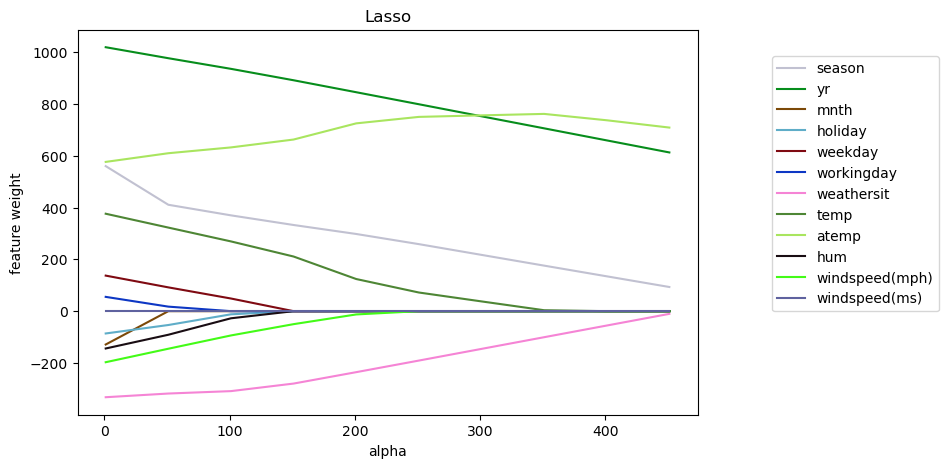

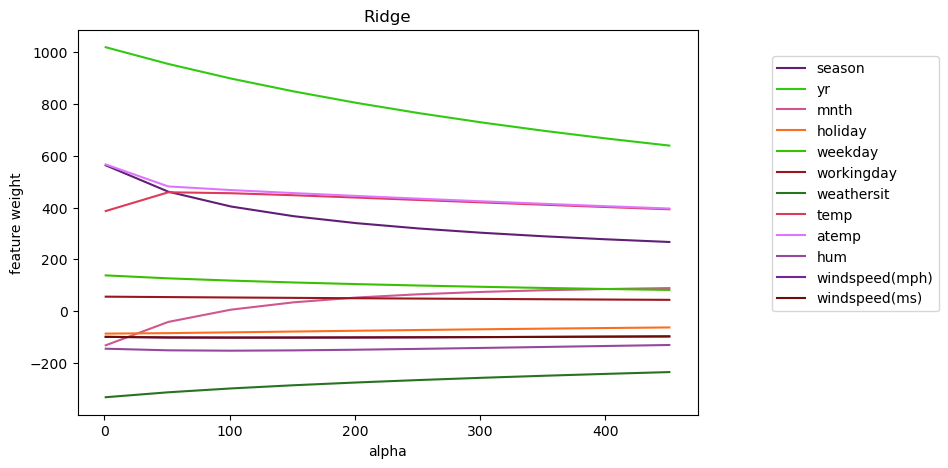

In [20]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

#### 9. [1 балл] Ответьте на следующие вопросы, глядя на графики или выводя коэффициенты на печать.

Ответьте на вопросы (каждый 0.25 балла):
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: веса зануляются, потому что большие значения alpha увеличивают штраф за большие веса и заставляют алгоритм устремлять их к 0
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Да, так как они линейно зависимы, а лассо способствует разреженности в пространстве признаков. Ридж нет.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Лассо, так как он их зануляет

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [21]:
from sklearn.linear_model import LassoCV

#### 10. [2 балла] Обучите регрессор LassoCV на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам MSE в зависимости от alpha. Выберите лучший alpha с точки зрения _усредненного_ MSE.


Пояснение:

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

In [28]:
alphas = np.arange(1, 100, 5)
from sklearn.linear_model import LassoCV

for alpha in alphas:
    regr4 = LassoCV(alphas = alphas).fit(df.drop(columns = "cnt"), df["cnt"])

    
for i in range(len(df.columns)-1):
    print(df.columns[i],": ", regr4.coef_[i])

season :  532.018982841353
yr :  1015.0602226430592
mnth :  -100.0395261435659
holiday :  -83.29395987529924
weekday :  132.5044654909581
workingday :  51.557085614073884
weathersit :  -330.5598567399813
temp :  370.67985503003337
atemp :  581.3969310654983
hum :  -140.00740550068883
windspeed(mph) :  -191.77140847134748
windspeed(ms) :  -2.6857771703854926e-08


Наконец, как принято в анализе данных, давайте проинтерпретируем результат.
Для ответов на вопросы используйте Lasso модель с лучшим alpha, найденным в прошлом пункте.

#### 11. [1.5 балла] Ответьте на вопросы, каждый 0.5 балла
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэффициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: yr, atemp, temp, season. С каждым годом количество аренд не очень сильно, но растет. Температура и ощущаемая температура линейно корелируют с cnt, но при слишком большой температуре люди не захотят кататься, да и вообще из дома выходить. На графике сезона видно, что зимой аренд мало, весной и осенью больше, а летом много. Тут зависимость не очень линейная.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: hum, windspeed(mph), weathersit. Некоторая линейная зависимость видна только у weathersit. Действительно,чем хуже погода, тем менее охотно люди будут арендовать велосипеды. Но про влажность и скорость ветра, несмотря на отсутствие явной линейной зависимости, можно сказать то же самое. Это означает что эти 2 признака вносят небольшой вклад.
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: windspeed(ms) единственный < 10^-3. workingday, holiday тоже имеют не большие значение по сравнению с другими признаками. windspeed(ms) имеет настолько маленький коэффициент, потому что модель уже учла windspeed(mph), от которого линейно зависит скорость в метрах в секунду. workingday в целом не сильно влияет. влияние holiday не очень велико, потому что данных с holiday=1 гораздо меньше (что в принципе логично, так как праздников намного меньше, чем не праздников) и разброс и с holiday=0, и с holiday=1 достаточно большой.

### Заключение

![burn](./display.jpeg)

Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.

## Дополнительные баллы:
### 12. [0.5 балла]: все графики выполнены аккуратно и подписаны
### 13. [0.5 балла]: прикрепите свой любимый анекдот, баллы получат несколько лучших

**Штирлиц сидел у камина и вязал. Вязание успокаивало Штирлица. После окончания вязания у камина остался лежать связанный Мюллер.**

*Итого*: максимум 11/10